In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

GPU available


# GPs with cellij
from: https://pyro.ai/examples/gp.html

In [127]:
import torch
import gpytorch
import pyro
import pandas as pd
import numpy as np
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import umap

import cellij

pyro.set_rng_seed(0)

In [128]:
d = "guo"

if d == "guo":
    imp = cellij.core.Importer()
    mdata = imp.load_Guo2010()
    obs = mdata.obs
    adata = mdata["qPCR"]
    X = torch.tensor(adata.to_df().values).float()
    time = obs["division_scaled"]
    obs["label_encoded"] = obs["label"].map({"NoneValue": 0, "TE": -2, "ICM": 2, "EPI": 1.5, "PE": 2.5})

    obs_metadata = pd.DataFrame()
    obs_metadata["time"] = time
    obs_metadata["tissue"] = obs["label_encoded"] 
    obs_metadata.fillna(0, inplace=True)
    scaler = MinMaxScaler()

    # Fit and transform the column data
    obs_metadata['tissue'] = scaler.fit_transform(obs_metadata[['tissue']])

    
elif d == "mefisto":
    imp = cellij.core.Importer()
    mdata = imp.load_MEFISTO()
    adata = mdata["view1"]
    X = torch.tensor(adata.to_df().values).float()
    time = torch.tensor(np.linspace(0, 1, data.shape[0])).float()


obs_metadata

/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


,time,tissue
obs0_1,0.0,0.444444
obs1_1,0.0,0.444444
obs2_1,0.0,0.444444
obs3_1,0.0,0.444444
obs4_1,0.0,0.444444
...,...,...
obs432_64_TE,1.0,0.000000
obs433_64_TE,1.0,0.000000
obs434_64_TE,1.0,0.000000
obs435_64_TE,1.0,0.000000


In [89]:


class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, n_factors, init_lengthscale=5.,): 
        n_inducing = len(inducing_points)
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=n_inducing, batch_shape = torch.Size([n_factors]),
            )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            model=self, 
            inducing_points=torch.tensor(
                data=inducing_points,
                dtype=torch.float32
            ), 
            variational_distribution=variational_distribution, 
            learn_inducing_locations=False,
        )

        super().__init__(variational_strategy=variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean(
            batch_shape=torch.Size([n_factors]),
            )
        self.kernel = gpytorch.kernels.RBFKernel(batch_shape = torch.Size([n_factors]))
        self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
        self.covar_module.base_kernel.lengthscale = init_lengthscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [136]:


class MEFISTO(gpytorch.Module):
    def __init__(
        self,
        data,
        covariates: pd.DataFrame(),
        n_factors,
        device,
    ):
        super().__init__()
        pyro.clear_param_store()

        self.device = device
        self.n_factors = n_factors
        self.data = data
        self.metadata = torch.Tensor(
            covariates.values,
            device=device,
        ).squeeze() 
        self.inducing_points = torch.Tensor(
            covariates.drop_duplicates().values,
            device=device,
        ).squeeze()
        self.n_obs = self.data.shape[0]
        self.n_features = self.data.shape[1]
        self.to(device)
        
        self.plates = {
            "obs": pyro.plate("obs", self.n_obs, dim=-1, device=self.device),
            "factors": pyro.plate("factors", self.n_factors, dim=-2, device=self.device),
            "features": pyro.plate("features", self.n_features, dim=-3, device=self.device),
        }
        
        print(self.inducing_points.shape)
        self.gp = GPModel(
            inducing_points=self.inducing_points,
            n_factors=self.n_factors
        ).to(device=self.device)

                # self.w_init = _init_pca(self.time, 0) # Initialise X to PCA
        
    def model(self):
        pyro.module("gp", self)
        
        with self.plates["features"], self.plates["factors"]:
            w = pyro.sample(
                "w", 
                pyro.distributions.Normal(
                    torch.tensor(0.0, device=self.device), 
                    torch.tensor(1.0, device=self.device)
                )
            ).to(self.device).view(-1, self.n_features, self.n_factors, 1)

        with self.plates["factors"], self.plates["obs"]:
            z = pyro.sample(
                    "z",
                    self.gp.pyro_model(self.metadata),
                ).to(self.device).view(-1, 1, self.n_factors, self.n_obs)
        
        prod = torch.matmul(
            input=w.squeeze(),
            other=z.squeeze(),
        ).to(self.device).view(-1, self.n_features, 1, self.n_obs)

        with self.plates["features"], self.plates["obs"]:
            pyro.sample(
                name='obs',
                fn=pyro.distributions.Normal(prod, 1.),
                obs=self.data.T.view(-1, self.n_features, 1, self.n_obs),
            ).to(self.device)

    def guide(self):
        w_loc = pyro.param('w_loc',  init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=0.0,
                dtype=torch.float32,
                device=self.device,
            )).view(-1, self.n_features, self.n_factors, 1)
        w_scale = pyro.param('w_scale', init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=1.0,
                dtype=torch.float32,
                device=self.device,
            )).view(-1, self.n_features, self.n_factors, 1)
        
        with self.plates["features"], self.plates["factors"]:
            pyro.sample(
                "w", 
                pyro.distributions.Normal(w_loc, w_scale)
            ).to(self.device).view(-1, self.n_features, self.n_factors, 1)
        
        with self.plates["factors"], self.plates["obs"]:
            pyro.sample(
                    "z",
                    self.gp.pyro_guide(self.metadata),
            ).to(self.device).view(-1, 1, self.n_factors, self.n_obs)

    def inference(self, num_particles=15, max_epochs=1000):
        self.optimizer = pyro.optim.Adam({"lr": 1e-3})

        elbo = pyro.infer.Trace_ELBO(
            retain_graph=True,
            num_particles=num_particles,
            vectorize_particles=True,
        )

        svi = pyro.infer.SVI(
            model=self.model,
            guide=self.guide,
            optim=self.optimizer,
            loss=elbo,
        )

        self.train()
        self.losses = []
        for epoch in range(max_epochs):
            self.zero_grad()
            loss = svi.step()
            self.losses.append(loss)
            if epoch % 500 == 0:
                print(epoch, loss)
                
    def get_factors(
        self,
        n_samples: int=25,
        ) -> torch.tensor:
        """Get the inferred means of the factors.
        
        Args:
            n_samples: number of samples to use for mean estimate

        Returns:
            tensor of shape (n_cells, n_factors, res, res)
        """
        self.eval()
        
        factor_means = []
        with torch.no_grad():
            dist = self.gp(self.metadata)
            samples = dist(torch.Size([n_samples])).cpu()
            mean = samples.mean(dim=0)
            mean = torch.transpose(mean, -1, -2)
            factor_means.append(torch.transpose(mean, -1, -2))

        factor_means = torch.stack(factor_means, dim=0)

        self.train()

        return factor_means

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MEFISTO(data=X, covariates=obs_metadata[["time"]], n_factors=4, device=device)
model.inference(num_particles=10, max_epochs=1)

torch.Size([7])


/tmp/ipykernel_3283859/2149676682.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points=torch.tensor(


0 59547.1625


In [137]:
model.inference(num_particles=10, max_epochs=10000)

0 57438.43193359375
500 35508.05938720703
1000 32965.21586914062
1500 31578.009350585937
2000 30601.684826660156
2500 30299.609045410158
3000 30262.983251953126
3500 30257.13466796875
4000 30253.388232421876
4500 30255.93850097656
5000 30239.502893066405
5500 30237.95949707031
6000 30234.7
6500 30222.647387695313
7000 30210.51447753906
7500 30197.70926513672
8000 30178.476428222657
8500 30150.694909667967
9000 30129.111926269532
9500 30094.26552734375


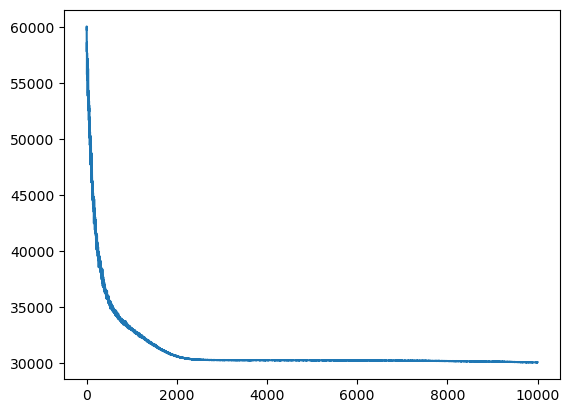

In [36]:
plt.plot(model.losses)

In [8]:
time = torch.tensor(obs_metadata[["time"]].values).float()

In [139]:
factor_means = []

df = torch.Tensor(obs_metadata[["time"]].values).float()

with torch.no_grad():
    dist = model.gp(df)
    samples = dist(torch.Size([10000])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)
factor_means.shape

torch.Size([1, 4, 437])

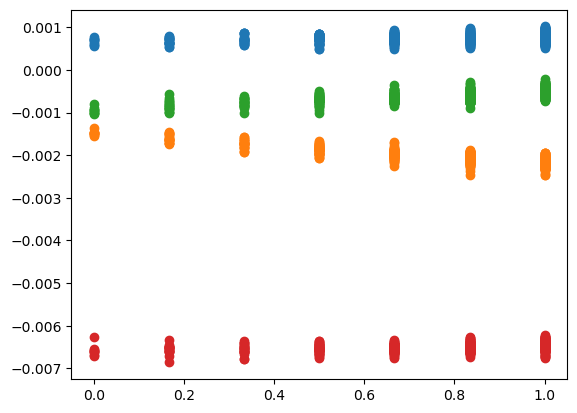

In [140]:
for i in range(4):
    plt.scatter(df.cpu().detach().numpy(), factor_means.squeeze()[i], )

In [141]:
from sklearn.decomposition import PCA

clustermethod = "umap"

if clustermethod == "pca":

    pca = PCA(n_components=2)

    # Fit the PCA model to your data
    result = pca.fit_transform(factor_means.squeeze().T)

elif clustermethod == "umap":

    # Create a UMAP object with desired parameters
    umap_obj = umap.UMAP()
    # Fit the UMAP model to your matrix
    result = umap_obj.fit_transform(factor_means.squeeze().T)


             0         1  time label
0     2.571598  6.446237   0.0  None
1     2.759360  6.489712   0.0  None
2     3.318203  6.826388   0.0  None
3     2.681569  6.467064   0.0  None
4     2.552623  6.624625   0.0  None
..         ...       ...   ...   ...
432  11.577787  3.224110   1.0    TE
433  11.402927  4.133938   1.0    TE
434  11.080688  4.017385   1.0    TE
435   9.787157  5.652115   1.0    TE
436   7.962748  2.152092   1.0    TE

[437 rows x 4 columns]


/tmp/ipykernel_3283859/2653328383.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_labels)


Text(0.5, 1.0, 'tissue types')

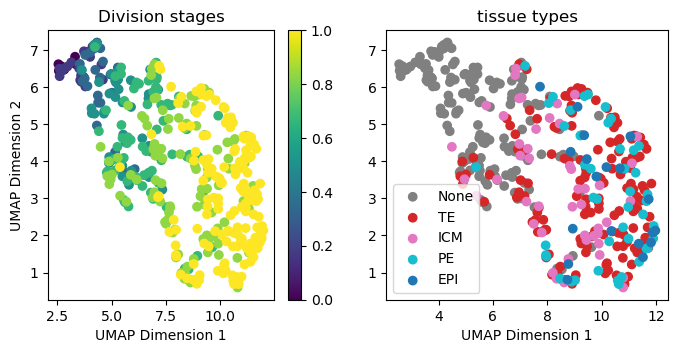

In [142]:
result = pd.DataFrame(result)
result["time"] = obs_metadata["time"].values
result["label"] = mdata.obs.label.values
print(result)

label_set = set(result["label"]) - {None}
num_labels = len(label_set)
color_map = plt.cm.get_cmap('tab10', num_labels)
label_to_color = {label: color_map(i) for i, label in enumerate(label_set)}

# Assign colors to the points based on the labels
colors = [label_to_color[label] if label in label_to_color else 'gray' for label in result["label"]]
result["c"] = colors
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 3.5))
s = axs[0].scatter(result[0], result[1], c = result["time"])
fig.colorbar(s, ax=axs[0])
axs[0].set_xlabel('UMAP Dimension 1')
axs[0].set_ylabel('UMAP Dimension 2')
axs[0].set_title('Division stages')

result["label"] = [str(l) for l in result["label"]]

for lab in result["label"].unique():
    tmp = result.query(f"label == '{lab}'")
    c = (1.0, 1.0, 0.5, 1.0) if lab is None else tmp["c"]
    axs[1].scatter(tmp[0], tmp[1], c = c, label=str(lab))
    axs[1].legend()
    
axs[1].set_xlabel('UMAP Dimension 1')
axs[1].set_title("tissue types")

<Axes: >

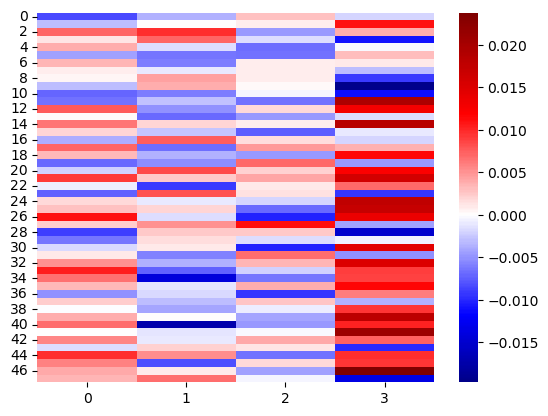

In [115]:
sns.heatmap(w, center=0, cmap="seismic")

(4, 437)


<Axes: >

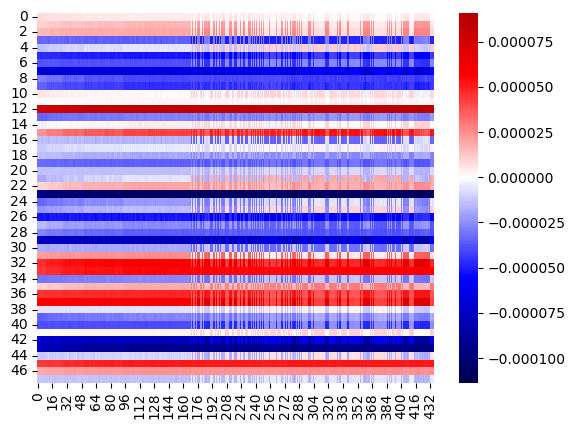

In [126]:
z = factor_means.squeeze().numpy()
print(f"{z.shape}")
w = pyro.param("w_loc").squeeze().cpu().detach().numpy()
sns.heatmap(w@z, center=0, cmap="seismic")

In [15]:
sns.heatmap(d.squeeze(), center=0, cmap="seismic")

AttributeError: 'str' object has no attribute 'squeeze'

In [ ]:
sns.heatmap(w.squeeze(), center=0, cmap="seismic")

In [ ]:
print(

np.array(d.T.squeeze())[:, 1] @  w[:, 1]

In [ ]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

test_x = torch.linspace(0, 1, 100).float()

model.eval()
with torch.no_grad():
    output = model.gp(test_x)

samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

In [ ]:
for k in range(2):
    # visualize the result
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    line, = ax.plot(test_x, mean[k].detach().cpu().numpy(), label='GP prediction')
    ax.fill_between(
        test_x, lower[k].detach().cpu().numpy(),
        upper[k].detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )

In [ ]:
plt.plot(